In [4]:
from google.colab import files
uploaded = files.upload()

Saving diabetes_prediction_dataset.csv to diabetes_prediction_dataset.csv


{0: 91500, 1: 8500}


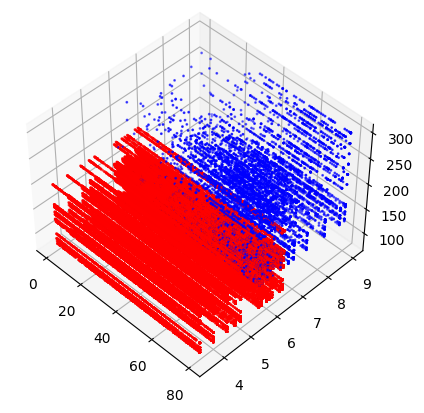

Entrenamiento (Score): 0.8818125
Prueba (score): 0.88655


KeyboardInterrupt: ignored

Error in callback <function _draw_all_if_interactive at 0x79e7ef1ddfc0> (for post_execute):


KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x79e7ef1dd240> (for post_execute):


KeyboardInterrupt: ignored

In [2]:
import pandas as pd
import numpy as np
import time
from numba import jit
from matplotlib import style
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Carga de Datos
data = pd.read_csv('diabetes_prediction_dataset.csv')

# Eliminamos valores vacios en la lista de datos
encoded_data = data.dropna()

# Se aplica Label Encoding para los campos que son clasificadores
encoded_data['gender'] = LabelEncoder().fit_transform(data['gender']).astype(np.float64)
encoded_data['smoking_history'] = LabelEncoder().fit_transform(data['smoking_history']).astype(np.float64)

def validate(partitions: tuple[int, ...], X: np.ndarray, Y: np.ndarray):
    assert isinstance(partitions, tuple), 'Las particiones deben ser una tupla de enteros.'
    assert sum(partitions) == 100, 'La suma de las particiones debe ser 100.'
    assert isinstance(X, np.ndarray), 'X debe ser un NDArray numpy'
    assert isinstance(Y, np.ndarray), 'Y debe ser un NDArray numpy'
    assert X.shape[0] == Y.shape[0], 'X e Y deben tener la misma dimensión.'

def split_sequential(partitions: tuple[int, ...], X: np.ndarray, Y: np.ndarray):
    validate(partitions, X, Y)

    length = X.shape[0]
    start_index = 0
    datasets = []
    for partition in partitions:
        step = round(partition / 100 * length)
        end_index = start_index + step
        datasets.append((X[start_index:end_index], Y[start_index:end_index]))
        start_index = end_index
    return datasets

def split_shuffle(partitions: tuple[int, ...], X: np.ndarray, Y: np.ndarray):
    X_shuffled, Y_shuffled = X.copy(), Y.copy()
    np.random.shuffle(X_shuffled)
    np.random.shuffle(Y_shuffled)

    datasets = split_sequential(partitions, X_shuffled, Y_shuffled)
    X_train, Y_train = datasets[0]
    X_test, Y_test = datasets[1]

    return X_train, Y_train, X_test, Y_test

# Se crea una matriz con las variables Independientes
columns = ['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level']

# Obtención de variables Independientes y concatenación
X = np.array([encoded_data[col].values for col in columns]).T

# Obtención de los datos de la variable Dependiente
Y = encoded_data['diabetes'].values.reshape(-1, 1)

# Estandarización de la matriz de variables independientes
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

X_train, Y_train, X_test, Y_test = split_shuffle((80, 20), X_standardized, Y)

# Distribución de los datos con y sin Diabetes
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
colores=['red','blue']
asignar=[]
values = {0: 0, 1: 0}

# Convertir Y a lista de Python
Y_list = Y.flatten().tolist()

for row in Y_list:
    values[row] = values.get(row, 0) + 1
    asignar.append(colores[row])

print(values)
ax.scatter(X[:, 1], X[:, 6], X[:, 7], c=asignar, s=1)
ax.view_init(elev=45, azim=-45)
plt.show()


######### Implementación y Predicciones de K-Means #########

def initialize_centroids(X, k):
    # Selecciona k puntos aleatorios como centroides iniciales
    indexes = np.random.choice(len(X), k, replace=False)
    return X[indexes]

def update_centroids(X, classifiers, k):
    # Calcula nuevos centroides basados en los puntos asignados a cada cluster
    return np.array([X[classifiers == i].mean(axis=0) for i in range(k)])

def k_means(X, k, iters=100, tol=0.001):
    centroids = initialize_centroids(X, k)
    for _ in range(iters):
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        classifiers = np.argmin(distances, axis=1)
        old_centroids = centroids
        centroids = update_centroids(X, classifiers, k)
        if np.linalg.norm(centroids - old_centroids) < tol:
            break
    return centroids, classifiers

# Creación de múltiples modelos K-means
k = 2
models = [k_means(X_train, k, 1000, 0.0001) for _ in range(50)]

# Evaluación y selección del mejor modelo
best_model = max(models, key=lambda model: accuracy_score(Y_test, np.argmin(np.linalg.norm(X_test[:, np.newaxis] - model[0], axis=2), axis=1)))

# Métricas de evaluación
train_accuracy = accuracy_score(Y_train, np.argmin(np.linalg.norm(X_train[:, np.newaxis] - best_model[0], axis=2), axis=1))
test_accuracy = accuracy_score(Y_test, np.argmin(np.linalg.norm(X_test[:, np.newaxis] - best_model[0], axis=2), axis=1))

print(f'Entrenamiento (Score): {train_accuracy}')
print(f'Prueba (score): {test_accuracy}')

######### Implementación y Predicciones de K-Means #########


# Visualización de los datos y centroides
colors = ['red', 'blue']
C = best_model[0]  # Centroides
classifiers = best_model[1]  # Clasificaciones
values = {0: 0, 1: 0}

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for row in classifiers:
    values[row] = values.get(row, 0) + 1
    color = colors[row]
    ax.scatter(X_test[:, 1], X_test[:, 6], X_test[:, 7], c=color, s=3, alpha=0.1)

ax.scatter(C[:, 1], C[:, 6], C[:, 7], marker='*', c=['#8c0000', '#000689'], s=1000, alpha=1)
ax.view_init(elev=45, azim=-15)
ax.set_xlabel('Age')
ax.set_ylabel('HbA1c_level')
ax.set_zlabel('blood_glucose_level')
plt.show()


######### Implementación y Predicciones de K-NN #########

# Calcula la distancia euclidiana vectorizada entre dos conjuntos de datos
@jit(nopython=True)
def euclidean_distance_vectorized(X_train, X_test):
    # Calcula las diferencias entre los conjuntos de datos
    differences = X_test - X_train
    # Calcula las distancias euclidianas al cuadrado para cada punto
    distances_squared = np.sum(differences**2, axis=1)
    # Obtiene las distancias euclidianas tomando la raíz cuadrada
    distances = np.sqrt(distances_squared)
    return distances

# Obtiene los índices de los k vecinos más cercanos basados en las distancias
@jit(nopython=True)
def get_neighbors_indexes(distances, k):
    # Ordena las distancias y devuelve los índices de los k vecinos más cercanos
    return np.argsort(distances)[:k]

# Realiza la predicción utilizando el algoritmo k-NN
def knn_predict(X_train, y_train, X_test, k=1):
    # Número de puntos en el conjunto de prueba
    n = X_test.shape[0]
    # Arreglo para almacenar las predicciones
    predictions = np.zeros(n, dtype=np.int64)

    # Itera sobre cada punto en el conjunto de prueba
    for i in range(n):
        # Calcula las distancias entre el punto actual y todos los puntos de entrenamiento
        distances = euclidean_distance_vectorized(X_train, X_test[i])
        # Obtiene los índices de los k vecinos más cercanos
        k_neighbors_indices = get_neighbors_indexes(distances, k)
        # Obtiene las etiquetas de los k vecinos más cercanos
        k_neighbors_labels = y_train[k_neighbors_indices]
        # Realiza la predicción tomando la etiqueta más común entre los vecinos más cercanos
        predictions[i] = np.bincount(k_neighbors_labels).argmax()

    return predictions

# Uso del algoritmo k-NN
start_time = time.time()
Y_pred = knn_predict(X_train, Y_train, X_test, k=2)
print(f'Prediction time: {time.time() - start_time}')
accuracy = accuracy_score(Y_test, Y_pred)
print(f'Accuracy: {accuracy}')

######### Implementación y Predicciones de K-NN #########


colors = ['red', 'blue']
asignar = []

# Visualización de los datos y Predicción utilizando k-NN
Y_pred = knn_predict(X_train, Y_train, X_test, k=2)

values = {0: 0, 1: 0}
for row in Y_pred.astype(np.int64):
    values[row] = values.get(row, 0) + 1
    asignar.append(colors[row])

print(values)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_test[:, 1], X_test[:, 6], X_test[:, 7], c=asignar, s=3, alpha=1)
ax.view_init(elev=45, azim=-45)
ax.set_xlabel('Age')
ax.set_ylabel('HbA1c_level')
ax.set_zlabel('blood_glucose_level')
plt.show()



